In [1]:
# Predicting Bee Colonies Survival 

In [2]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import sqlite3
from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler



In [3]:
## Load Database DB

database_path = Path("./stroke_predictions.db")

engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()
sql_query = "SELECT * FROM stroke_info"

df = pd.read_sql(sql_query, conn)


In [4]:
df.describe()

,index,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,2554.500000,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,1475.274268,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.000000,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,1277.250000,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,2554.500000,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,3831.750000,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,5109.000000,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [5]:
df = pd.get_dummies(df, columns=['gender'], dtype=int)
df = pd.get_dummies(df, columns=['ever_married'], dtype=int)
df = pd.get_dummies(df, columns=['work_type'], dtype=int)
df = pd.get_dummies(df, columns=['Residence_type'], dtype=int)
df = pd.get_dummies(df, columns=['smoking_status'], dtype=int)


df

,index,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,9046,67.0,0,1,228.69,36.6,1,0,1,...,0,1,0,0,0,1,0,1,0,0
1,1,51676,61.0,0,0,202.21,NaN,1,1,0,...,0,0,1,0,1,0,0,0,1,0
2,2,31112,80.0,0,1,105.92,32.5,1,0,1,...,0,1,0,0,1,0,0,0,1,0
3,3,60182,49.0,0,0,171.23,34.4,1,1,0,...,0,1,0,0,0,1,0,0,0,1
4,4,1665,79.0,1,0,174.12,24.0,1,1,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,5105,18234,80.0,1,0,83.75,NaN,0,1,0,...,0,1,0,0,0,1,0,0,1,0
5106,5106,44873,81.0,0,0,125.20,40.0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
5107,5107,19723,35.0,0,0,82.99,30.6,0,1,0,...,0,0,1,0,1,0,0,0,1,0
5108,5108,37544,51.0,0,0,166.29,25.6,0,0,1,...,0,1,0,0,1,0,0,1,0,0


In [6]:
df = df[['id', 'age', 'hypertension', 'heart_disease',
       'avg_glucose_level', 'bmi', 'stroke', 'gender_Female', 'gender_Male',
       'gender_Other', 'ever_married_No', 'ever_married_Yes',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes']]

In [7]:
df = df.dropna()

In [8]:
df

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
2,31112,80.0,0,1,105.92,32.5,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,60182,49.0,0,0,171.23,34.4,1,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,1665,79.0,1,0,174.12,24.0,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
5,56669,81.0,0,0,186.21,29.0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,13.0,0,0,103.08,18.6,0,1,0,0,...,0,0,0,1,1,0,1,0,0,0
5106,44873,81.0,0,0,125.20,40.0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
5107,19723,35.0,0,0,82.99,30.6,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
5108,37544,51.0,0,0,166.29,25.6,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0


In [9]:
# Model Iteration 1

In [10]:
y = df["stroke"]
X = df[['age', 'hypertension', 'heart_disease',
       'avg_glucose_level', 'bmi',  'gender_Female', 'gender_Male',
       'gender_Other', 'ever_married_No', 'ever_married_Yes',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes']]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1 
                                                    )
X_train.shape

(3681, 21)

In [12]:
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [13]:
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=2500,
                                random_state=1)
classifier

LogisticRegression(max_iter=2500, random_state=1)

In [14]:
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=2500, random_state=1)

In [15]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.9592502037489813
Testing Data Score: 0.9527687296416938


In [16]:
predictions = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [17]:
accuracy_score(y_test, predictions)

0.9527687296416938

In [18]:
# Model Iteration 2

In [19]:
df = df[df["age"] > 2]
df

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
2,31112,80.0,0,1,105.92,32.5,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,60182,49.0,0,0,171.23,34.4,1,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,1665,79.0,1,0,174.12,24.0,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
5,56669,81.0,0,0,186.21,29.0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,13.0,0,0,103.08,18.6,0,1,0,0,...,0,0,0,1,1,0,1,0,0,0
5106,44873,81.0,0,0,125.20,40.0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
5107,19723,35.0,0,0,82.99,30.6,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
5108,37544,51.0,0,0,166.29,25.6,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0


In [20]:
y = df["stroke"]
X = df[['age', 'hypertension', 'heart_disease',
       'avg_glucose_level', 'bmi',  'gender_Female', 'gender_Male',
       'gender_Other', 'ever_married_No', 'ever_married_Yes', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes']]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1 
                                                    )
X_train.shape

(3555, 14)

In [22]:
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


In [23]:
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=2500,
                                random_state=1)
classifier

LogisticRegression(max_iter=2500, random_state=1)

In [24]:
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=2500, random_state=1)

In [25]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.9578059071729957
Testing Data Score: 0.9510548523206751


In [26]:
predictions = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [27]:
accuracy_score(y_test, predictions)

0.9510548523206751

In [28]:
# Model Iteration 3

In [29]:
y = df["stroke"]
X = df[['age', 'hypertension', 'heart_disease',
       'avg_glucose_level', 'bmi',  'gender_Female', 'gender_Male',
       'gender_Other', 'ever_married_No', 'ever_married_Yes', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes']]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1 
                                                    )
X_train.shape

(3555, 14)

In [31]:
scaler = StandardScaler()

In [32]:
X_scaler = scaler.fit(X_train)

In [33]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [34]:
rf_model = RandomForestClassifier(n_estimators=2500, random_state=78)

In [35]:
rf_model = rf_model.fit(X_train_scaled, y_train)

In [36]:
predictions = rf_model.predict(X_test_scaled)

In [37]:
acc_score = accuracy_score(y_test, predictions)
acc_score

0.9510548523206751

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

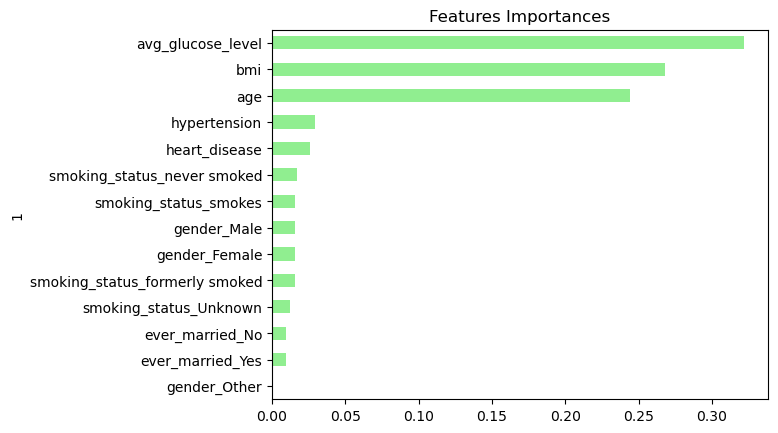

In [38]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [39]:
# Model Iteration 4

In [40]:
y = df["stroke"]
X = df[['age',
       'avg_glucose_level', 'bmi',]]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1 
                                                    )
X_train.shape

(3555, 3)

In [42]:
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


In [43]:
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=2500,
                                random_state=1)
classifier

LogisticRegression(max_iter=2500, random_state=1)

In [44]:
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=2500, random_state=1)

In [45]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.9575246132208157
Testing Data Score: 0.9510548523206751


In [46]:
predictions = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [47]:
accuracy_score(y_test, predictions)

0.9510548523206751

In [48]:
# Model Iteration 5

In [49]:
df = df[df["age"] > 45]
df

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
2,31112,80.0,0,1,105.92,32.5,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,60182,49.0,0,0,171.23,34.4,1,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,1665,79.0,1,0,174.12,24.0,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
5,56669,81.0,0,0,186.21,29.0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5097,64520,68.0,0,0,91.68,40.8,0,0,1,0,...,0,0,1,0,0,1,1,0,0,0
5100,68398,82.0,1,0,71.97,28.3,0,0,1,0,...,0,0,1,0,1,0,0,0,1,0
5102,45010,57.0,0,0,77.93,21.7,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
5106,44873,81.0,0,0,125.20,40.0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0


In [50]:
y = df["stroke"]
X = df[['age', 'hypertension', 'heart_disease',
       'avg_glucose_level', 'bmi',  'gender_Female', 'gender_Male',
       'gender_Other', 'ever_married_No', 'ever_married_Yes', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes']]

In [51]:
scaler = StandardScaler()

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1 
                                                    )
X_train.shape

(1771, 14)

In [53]:
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=2500,
                                random_state=1)
classifier

LogisticRegression(max_iter=2500, random_state=1)

In [54]:
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=2500, random_state=1)

In [55]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.9130434782608695
Testing Data Score: 0.9255499153976311


In [56]:
predictions = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [57]:
accuracy_score(y_test, predictions)

0.9255499153976311